## Data/MC Comparison for Brem-Induced Clusters

#### Comparison of Clusters in Data vs MC. This is to validate the signal reconstruction process. We compare cluster from Z->MuMu events in Data vs those from a DY->ZMuMu (50-120 GeV for MLL). Both Data and MC are from 2023B, with an initial DBSCAN skim applied

In [1]:
import numpy as np
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")
import mplhep as hep
import pickle
import glob
import ROOT as rt
import coffea
import awkward as ak
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector


Welcome to JupyROOT 6.28/00


In [2]:
sys.path.append("/uscms/home/amalbert/nobackup/CMSSW_14_1_0_pre4/src/RazorCommon/Tools/bin")
import importlib
import getMuonScaleFactor

In [58]:
#paths
#data_path = "/eos/uscms/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/Run2023B_skim_TnPOutput_MuonFilters_goodLumi.root"
#MC_path = "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/MCSummer23_DY50to120_postBPix_TnP_Output_DNNVariables_forDNN_617pb_weighted.root"
MC_path = "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/testMC_matchTrigObj_printTagCount.root"
#data_path = "/eos/uscms/store/group/lpclonglived/amalbert/Data_MC_Comp_TnP/MCSummer23_DY50to120_postBPix_newestTnP_Output_617pb_weighted.root"
data_path= "/uscms/home/amalbert/nobackup/CMSSW_10_6_20/src/run3_llp_analyzer/Run2023B_TnP_matchTriggerObj_goodLumi.root"

In [59]:
data_TFile = rt.TFile(data_path)
MC_TFile = rt.TFile(MC_path)

data_tree = data_TFile.Get("MuonSystem")
MC_tree = MC_TFile.Get("MuonSystem")

Error in <THashList::Delete>: A list is accessing an object (0x13235a50) already deleted (list name = THashList)


In [60]:
ak.behavior.update(candidate.behavior)

def getLZDF(f,nEvents=-1,version="new"): #lazy dataframe with events that have cluster matched to probe muon
    events_raw = uproot.open(f)['MuonSystem']
    df = coffea.processor.LazyDataFrame(events_raw,entrystop=nEvents)
    start,stop = df._branchargs['entry_start'],df._branchargs['entry_stop']
    events = uproot.lazy(df._tree)
    events = events[start:stop]
    return events

In [61]:
events_data = getLZDF(data_path)
events_MC = getLZDF(MC_path)

In [62]:
events_data.fields

['runNum',
 'MC_condition',
 'lumiSec',
 'evtNum',
 'mH',
 'mX',
 'ctau',
 'category',
 'npv',
 'npu',
 'weight',
 'lepOverallSF',
 'pileupWeight',
 'numProbeMuons',
 'Flag_HBHENoiseFilter',
 'Flag_BadPFMuonFilter',
 'Flag_BadPFMuonDzFilter',
 'Flag_HBHEIsoNoiseFilter',
 'Flag_CSCTightHaloFilter',
 'Flag_globalSuperTightHalo2016Filter',
 'Flag_goodVertices',
 'Flag_ecalBadCalibFilter',
 'Flag_BadChargedCandidateFilter',
 'Flag_eeBadScFilter',
 'Flag_hfNoisyHitsFilter',
 'Flag_all',
 'Flag2_HBHENoiseFilter',
 'Flag2_HBHEIsoNoiseFilter',
 'Flag2_BadPFMuonFilter',
 'Flag2_globalSuperTightHalo2016Filter',
 'Flag2_globalTightHalo2016Filter',
 'Flag2_BadChargedCandidateFilter',
 'Flag2_EcalDeadCellTriggerPrimitiveFilter',
 'Flag2_ecalBadCalibFilter',
 'Flag2_eeBadScFilter',
 'Flag2_all',
 'rho',
 'met',
 'metPhi',
 'gHiggsPt',
 'gHiggsE',
 'gHiggsEta',
 'gHiggsPhi',
 'nCscRings',
 'nDtRings',
 'nCscRechitClusters',
 'cscRechitCluster_match_gLLP',
 'cscRechitCluster_match_gLLP_minDeltaR',
 'c

In [63]:
events_data.lepTag[15]

<Array [True, True] type='2 * bool'>

In [64]:
events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo

<Array [[0.895, -1e+03, ... -1e+03, -1e+03]] type='1348 * 30 * float32'>

In [65]:
data_tree.GetEntries()

1349

In [66]:
importlib.reload(getMuonScaleFactor)
data_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(np.array(events_data.lepPt), np.array(events_data.lepEta))
MC_SF_LooseID = getMuonScaleFactor.getLooseIDEffArr_BPix(np.array(events_MC.lepPt), np.array(events_MC.lepEta))

In [67]:
eventsTwoClusters_data = events_data[events_data.nCscRechitClusters==2]

In [68]:
ak.size(eventsTwoClusters_data.runNum)

253

In [69]:
print(ak.count_nonzero(ak.flatten(events_MC.cscRechitCluster_matchToProbeMuon)))
print(ak.count_nonzero(ak.flatten(events_MC.cscRechitCluster_matchToProbeAndJet)))

3259
3256


In [120]:
def makeEventMask(events, noMaskList: list=[]):
    mask = ak.flatten(events.cscRechitCluster_matchToProbeMuon)
    if "forward_veto" not in noMaskList:
        mask = ak.mask(mask, ak.flatten(events.cscRechitCluster_passME1112Veto))
    if "timespread_veto" not in noMaskList:
        mask = ak.mask(mask, ak.flatten(events.cscRechitClusterTimeSpreadWeightedAll)<20)
    if "time_veto" not in noMaskList:
        mask = ak.mask(mask, ak.flatten(events.cscRechitClusterTimeWeighted)<12.5)
        mask = ak.mask(mask, ak.flatten(events.cscRechitClusterTimeWeighted)>-5)
    if "DNN_veto" not in noMaskList:
        remove9999 = ak.mask(ak.flatten(events.cscRechitClusterDNN_bkgMC_plusBeamHalo), ak.flatten(events.cscRechitClusterDNN_bkgMC_plusBeamHalo)>0)
        remove9999 = remove9999[~ak.is_none(remove9999)]
        DNNMask = remove9999>0.96
        mask = ak.mask(mask, DNNMask)
    if "clusterSize_veto" not in noMaskList:
        mask = ak.mask(mask, ak.flatten(events.cscRechitClusterSize)>160)
    
    return mask

In [145]:
# data efficiencies
oneClusterData = ak.mask(events_data, events_data.nCscRechitClusters==1)
oneClusterData = oneClusterData[~ak.is_none(oneClusterData)]
num = ak.count_nonzero(makeEventMask(oneClusterData))
print("Data Numerator: ", num)

denom_forward = ak.count_nonzero(makeEventMask(oneClusterData, ['forward_veto']))
print("Forward Veto Efficiency: ", num/denom_forward*100)

denom_timespread = ak.count_nonzero(makeEventMask(oneClusterData, ['timespread_veto']))
print("Timespread Veto Efficiency: ", num/denom_timespread*100)

denom_time = ak.count_nonzero(makeEventMask(oneClusterData, ['time_veto']))
print("Time Veto Efficiency: ", num/denom_time*100)

denom_DNN = ak.count_nonzero(makeEventMask(oneClusterData, ['DNN_veto']))
print("DNN Veto Efficiency: ", num/denom_DNN*100)

denom_clusterSize = ak.count_nonzero(makeEventMask(oneClusterData, ['clusterSize_veto']))
print("ClusterSize Veto Efficiency: ", num/denom_clusterSize*100)

Data Numerator:  12
Forward Veto Efficiency:  92.3076923076923
Timespread Veto Efficiency:  100.0
Time Veto Efficiency:  85.71428571428571
DNN Veto Efficiency:  36.36363636363637
ClusterSize Veto Efficiency:  12.0


In [141]:
# MC efficiencies
oneClusterMC = ak.mask(events_MC, events_MC.nCscRechitClusters==1)
oneClusterMC = oneClusterMC[~ak.is_none(oneClusterMC)]
masked_weights = ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC))
num = ak.sum(masked_weights)
print("MC Numerator: ", num)

denom_forward = ak.sum(ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC, ['forward_veto'])))
print("Forward Veto Efficiency: ", num/denom_forward*100)

denom_timespread = ak.sum(ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC, ['timespread_veto'])))
print("Timespread Veto Efficiency: ", num/denom_timespread*100)

denom_time = ak.sum(ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC, ['time_veto'])))
print("Time Veto Efficiency: ", num/denom_time*100)

denom_DNN = ak.sum(ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC, ['DNN_veto'])))
print("DNN Veto Efficiency: ", num/denom_DNN*100)

denom_clusterSize = ak.sum(ak.mask(oneClusterMC.weight, makeEventMask(oneClusterMC, ['clusterSize_veto'])))
print("ClusterSize Veto Efficiency: ", num/denom_clusterSize*100)

MC Numerator:  55.052162
Forward Veto Efficiency:  95.83332538604736
Timespread Veto Efficiency:  100.0
Time Veto Efficiency:  100.0
DNN Veto Efficiency:  53.24074029922485
ClusterSize Veto Efficiency:  22.86282181739807


In [113]:
MC_tree.GetEntries()

3163

In [80]:
ak.mask(ak.flatten(events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo), ak.flatten(events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo)>0)
np.count_nonzero(ak.mask(ak.flatten(events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo), ak.flatten(events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo)>0))

1650

In [77]:
ak.flatten(events_data.cscRechitClusterDNN_bkgMC_plusBeamHalo)

<Array [0.895, -1e+03, ... -1e+03, -1e+03] type='40440 * float32'>

In [95]:
rt.gStyle.SetOptStat(0)
def make_ratio_plot(h_list_in, title = "", label = "", fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2','E1'], text = "", scale=False, scales = [1,1]):
    h_list = []
    if in_tags == None:
        tag = []
    else:
        tag = in_tags
    for i, h in enumerate(h_list_in):
        h_list.append(h.Clone('h{}aux{}'.format(i, label)))
        if in_tags == None:
            tag.append(h.GetTitle())
    #print("tags: ", tag)
    c_out = rt.TCanvas("c_out_ratio"+label, "c_out_ratio"+label, 800, 800)
    pad1 = rt.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
    pad1.SetBottomMargin(0.03)
    pad1.SetLeftMargin(0.15)
    pad1.SetRightMargin(0.04)# pad2.SetGrid()
    if logy:
        pad1.SetLogy()

    pad1.Draw()
    pad1.cd()

    leg = rt.TLegend(0.5, 0.65, 0.9, 0.92)
    leg = rt.TLegend(0.7, 0.65, 0.9, 0.92)

    #leg = rt.TLegend(0.2, 0.7, 0.5, 0.9)
    # leg = rt.TLegend(0.7, 0.2, 0.9, 0.4)
    leg.SetBorderSize(0)
    leg.SetTextSize(0.045)
    leg.SetFillStyle(0)
    c_out.cd(1)

    scaled_h_list = []
    if scale:
        for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #h = h_unscaled.Scale(1/scales[i])
            #scaled_h_list.append(h_unscaled.Clone())
            h_unscaled.Scale(1/scales[i])
            scaled_h_list.append(h_unscaled)
    else:
        #for i, h_unscaled in enumerate(h_list):
            #h = h_unscaled.Clone()
            #scaled_h_list.append(h)
        scaled_h_list = h_list
    for i, h in enumerate(scaled_h_list):
        h.GetXaxis().SetLabelSize(0)
        h.GetXaxis().SetTitle(label)
        h.GetYaxis().SetRangeUser(0, 1.1*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        if logy:
            h.GetYaxis().SetRangeUser(10e-2, 2*max(map(lambda x: x.GetMaximum(), scaled_h_list)))
        h.GetYaxis().SetTitleOffset(1.0)
        h.GetYaxis().SetTitleSize(0.06)
        h.GetYaxis().SetLabelSize(0.05)
        
        if scale:
            y_title = "Fraction of Events"
        else:
            y_title = "Events"
        
        h.GetYaxis().SetTitle()
        h.SetTitle(f"{title};adsf;{y_title}")
        #if ratio_index == 0:h.DrawCopy("hist")
        h.SetFillColor(h_list_in[i].GetLineColor())
        h.SetFillStyle(3002)
        #h.SetStats(1)
        h.SetLineColor(h_list_in[i].GetLineColor())
        h.SetLineWidth(2)
        h.SetMarkerColor(h_list_in[i].GetLineColor())
        h.SetMarkerSize(2)
        # if ratio_index == 0:
        #     # h.DrawCopy("hist")
        #     h.DrawCopy(draw_opt[i]+'same')
        # else:h.DrawCopy(draw_opt[i])
        #if ratio_index == 0 :h.DrawCopy(draw_opt[i]+"same")
        #h.DrawCopy("E2 HIST")
        if i==0:
            h.DrawCopy(draw_opt[i])
        else:
            h.DrawCopy(draw_opt[i] + "same")
        #else:h.DrawCopy(draw_opt[i])
        if len(text)>0:
            l = rt.TLatex()
            l.SetTextSize(0.045)
            if logy:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()/10, text)
            else:l.DrawLatex((h.GetXaxis().GetXmax()-h.GetXaxis().GetXmin())*0.1+h.GetXaxis().GetXmin() , h.GetMaximum()*0.8, text)
        #if i==1:
            #h.DrawCopy(draw_opt[i]+"same")
       #     h.Draw("E1 same")

        leg.AddEntry(h, tag[i], "lep")
    leg.Draw("same")

    c_out.cd()
    pad2 = rt.TPad("pad2", "pad2", 0, 0, 1, 0.3)
    pad2.SetTopMargin(0.03)
    pad2.SetBottomMargin(0.25)
    pad2.SetLeftMargin(0.15)
    pad2.SetRightMargin(0.04)# pad2.SetGrid()
    pad2.Draw()
    pad2.cd()
    band = scaled_h_list[ratio_index].Clone('h_band')
    for j in range(band.GetXaxis().GetNbins()):
        band.SetBinContent(j+1, 1.0)
        if h_list[ratio_index].GetBinContent(j+1) == 0:
            band.SetBinError(j+1, 0.0)
        else:
            band.SetBinError(j+1, scaled_h_list[ratio_index].GetBinError(j+1)/scaled_h_list[ratio_index].GetBinContent(j+1))
            #print(j, h_list_in[0].GetBinError(j+1)/h_list_in[0].GetBinContent(j+1))
    band.SetFillColor(scaled_h_list[ratio_index].GetLineColor())

    band.SetFillStyle(3002)
    band.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    #band.SetFillColorAlpha(0,0)
    #band.SetLineColor(0)
    
    band.GetYaxis().SetTitleOffset(0.5)
    band.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
    band.GetYaxis().SetTitleSize(0.11)
    band.GetYaxis().SetLabelSize(0.12)
    band.GetYaxis().SetNdivisions(506)
    band.GetXaxis().SetTitleOffset(0.95)
    band.GetXaxis().SetTitleSize(0.12)
    band.GetXaxis().SetLabelSize(0.12)
    band.GetXaxis().SetTickSize(0.07)
    
    band.SetYTitle('Ratio with {}'.format(tag[ratio_index]))
    band.SetXTitle(label)
    band.SetTitle("")
    band.DrawCopy('E2')
    ln = rt.TLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
    ln.SetLineWidth(3)
    ln.SetLineColor(scaled_h_list[ratio_index].GetLineColor())
    ln.DrawLine(h.GetXaxis().GetXmin(), 1, h.GetXaxis().GetXmax(), 1)
     
    #print(ratio_index)
    for i, h in enumerate(scaled_h_list):
        if i == ratio_index:
            continue
        else:
            if fit:h.GetFunction("expo")
            h.Divide(scaled_h_list[ratio_index])
            # h.GetYaxis().SetTitleOffset(0.6)
            # h.GetYaxis().SetRangeUser(ratio_bounds[0], ratio_bounds[1])
            # h.GetYaxis().SetTitleSize(0.12)
            # h.GetYaxis().SetLabelSize(0.12)
            # h.GetYaxis().SetNdivisions(506)
            # h.GetXaxis().SetTitleOffset(0.95)
            # h.GetXaxis().SetTitleSize(0.12)
            # h.GetXaxis().SetLabelSize(0.12)
            # h.GetXaxis().SetTickSize(0.07)
            # h.SetYTitle('Ratio with {}'.format(tag[0]))
            # h.SetTitle("")
            #set relative error of ratio to be the relative error of data
            for j in range(h.GetXaxis().GetNbins()):
                if h_list[i].GetBinContent(j+1) == 0:
                    h.SetBinError(j+1, 0.0)
                else:
                    h.SetBinError(j+1, h_list_in[i].GetBinError(j+1)/h_list_in[i].GetBinContent(j+1)*h.GetBinContent(j+1))
            h.Draw('same'+draw_opt[i])
    
    pad2.Update()
    
    c_out.pad1 = pad1
    c_out.pad2 = pad2
    c_out.h_list = h_list
    c_out.leg = leg
    
    return c_out

### ZMass Comparison of Selected Events

In [109]:
plot_info = {}
plot_output = "Run2023B_Data_MC_Comp"

In [122]:
branch = "ZMass"
name = branch
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=150)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data.Fill(getattr(data_tree, branch))
data.SetLineColor(rt.kBlack)
data.SetFillStyle(0)

MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=150)
sumOfWeights=0
for entry in MC_tree:
    MC.Fill(getattr(MC_tree, branch), getattr(MC_tree, "weight"))
    sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
MC.SetFillStyle(0)
plot_info[branch] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Z Candidate Mass", "label": "Z Candidate Mass [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [123]:
branch = "lepPt"
name = "LeadingPt"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data.Fill(getattr(data_tree, branch)[0])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC.Fill(getattr(MC_tree, branch)[0], getattr(MC_tree, "weight"))
    sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Leading Muon pT Comparison", "label": "Leading Muon pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [124]:
branch = "lepPt"
name = "SubleadingPt"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data.Fill(getattr(data_tree, branch)[1])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC.Fill(getattr(MC_tree, branch)[1], getattr(MC_tree, "weight"))
    sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Subleading Muon pT Comparison", "label": "Subleading Muon pT [GeV])", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [125]:
branch = "lepTag"
name = "LepTagCount"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=4, xlow = 0, xup=4)
for entry in data_tree:
    counter=0
    for i in range(data_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            counter+=1
    data.Fill(counter)
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=4, xlow = 0, xup=4)
for entry in MC_tree:
    counter=0
    for i in range(MC_tree.nLeptons):
        if MC_tree.lepTag[i]==1:
            counter+=1
    MC.Fill(counter, MC_tree.weight)
    sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Muons in Event Passing Tag Criteria", "label": "Number of Tag Muons", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [126]:
branch = "lepTag"
name = "LepTagCount"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=4, xlow = 0, xup=4)
for entry in data_tree:
    counter=0
    for i in range(data_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            counter+=1
    data.Fill(counter)
data.SetLineColor(rt.kBlack)
    
sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=4, xlow = 0, xup=4)
for entry in MC_tree:
    counter=0
    for i in range(MC_tree.nLeptons):
        if MC_tree.lepTag[i]==1:
            counter+=1
        MC.Fill(counter,MC_tree.weight)
    sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Number of Muons in Event Passing Tag Criteria", "label": "Number of Tag Muons", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [127]:
branch = "lepPt"
name = "LepTagPt"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=120)
for entry in data_tree:
    for i in range(data_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=120)
for entry in MC_tree:
    for i in range(MC_tree.nLeptons):
        if MC_tree.lepTag[i]==1:
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Tag Muon pT Comparison", "label": "Tag Muon pT [GeV]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [128]:
branch = "cscRechitClusterSize"
name = "clusterSize"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=40, xlow = 0, xup=400)
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)
data.Set

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=40, xlow = 0, xup=400)
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)

plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Size", "label": "N_{rechits}", "scales": [sumOfWeights, data.GetEntries()], "logy": True}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [129]:
branch = "cscRechitClusterEta"
name = "clusterEta"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -4, xup=4)
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -4, xup=4)
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Eta", "label": "Cluster Eta", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [130]:
branch = "cscRechitClusterPhi"
name = "clusterPhi"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=30, xlow = -4, xup=4)
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=30, xlow = -4, xup=4)
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Cluster Phi", "label": "Cluster Phi", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [131]:
branch = "cscRechitClusterTimeWeighted"
name = "clusterTime"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=60, xlow = -8, xup=20)
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=60, xlow = -8, xup=20)
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time", "label": "Weighted Cluster Time [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [132]:
branch = "cscRechitClusterTimeSpreadWeightedAll"
name = "clusterTimeSpread"
data = rt.TH1F("LeadingPt_Data", "Data", nbinsx=50, xlow = 0, xup=50)
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data.Fill(getattr(data_tree, branch)[i])
data.SetLineColor(rt.kBlack)

sumOfWeights=0
MC = rt.TH1F("LeadingPt_MC", "MC", nbinsx=50, xlow = 0, xup=50)
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC.Fill(getattr(MC_tree, branch)[i], MC_tree.weight)
            sumOfWeights+=getattr(MC_tree, "weight")
MC.SetLineColor(rt.kRed)
plot_info[name] = {"MC_hist": MC, "data_hist": data, "file_name": name, "title": "Weighted Cluster Time Spread", "label": "Weighted Cluster Time Spread [ns]", "scales": [sumOfWeights, data.GetEntries()], "logy": False}

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [133]:

for plot_type, plot_info_dict in plot_info.items():
    #print(plot_type)
    #print(plot_info_dict)
    for boolScale in [True, False]:
        c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = plot_info_dict["logy"], ratio_index = 0, draw_opt = ['E2 HIST','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        if boolScale:
            scaleString = "normalized"
            #c = make_ratio_plot([plot_info_dict["MC_hist"], plot_info_dict["data_hist"]], title = plot_info_dict["title"], label = plot_info_dict["label"], fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2 hist','E1'], text = "", scale=boolScale, scales = plot_info_dict["scales"])
        else:
            scaleString=""
        c.SaveAs(plot_output+"/"+plot_info_dict["file_name"]+scaleString+"_updatedTNP.png")
        

Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/ZMassnormalized_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioZ Candidate Mass [GeV]
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/ZMass_updatedTNP.png has been created
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/LeadingPtnormalized_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioLeading Muon pT [GeV]
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/LeadingPt_updatedTNP.png has been created
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/SubleadingPtnormalized_updatedTNP.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioSubleading Muon pT [GeV])
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/SubleadingPt_updatedTNP.png has been created
Info in <TCanvas::Print>: png file Run2023B_Data_MC_Comp/LepTagCountnorma

### Pt Comparison

tags:  ['MC', 'Data']


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratioZ Candidate Mass (GeV)


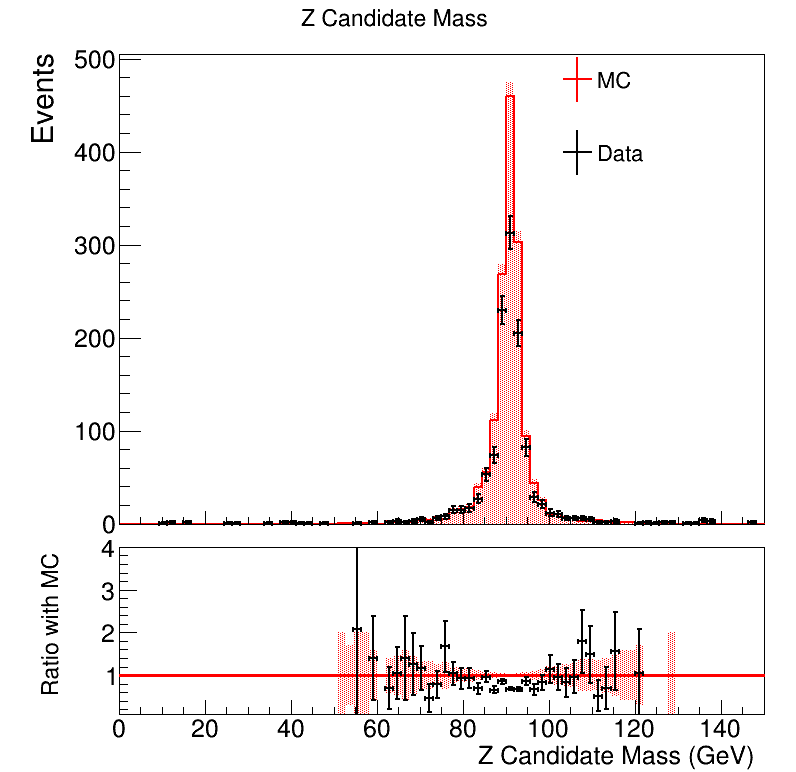

In [98]:

#c.Clear()
rt.gStyle.SetOptStat(0);
c = make_ratio_plot([MC_LeadingPt, data_LeadingPt], title = "Z Candidate Mass", label = "Z Candidate Mass (GeV)", fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['E2 hist','E1'], text = "", scale=False)
#legend = rt.TLegend(0.9,0.8,0.7,0.9)
#legend.AddEntry(data_LeadingPt, "Data")
#legend.AddEntry(MC_LeadingPt, "MC")
#legend.Draw()

#stack_leading.GetXaxis().SetTitle("Z Candidate Mass [GeV]");
#stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

<class cppyy.gbl.TH1F at 0x150afcf0>
<class cppyy.gbl.TH1F at 0x150afcf0>


Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


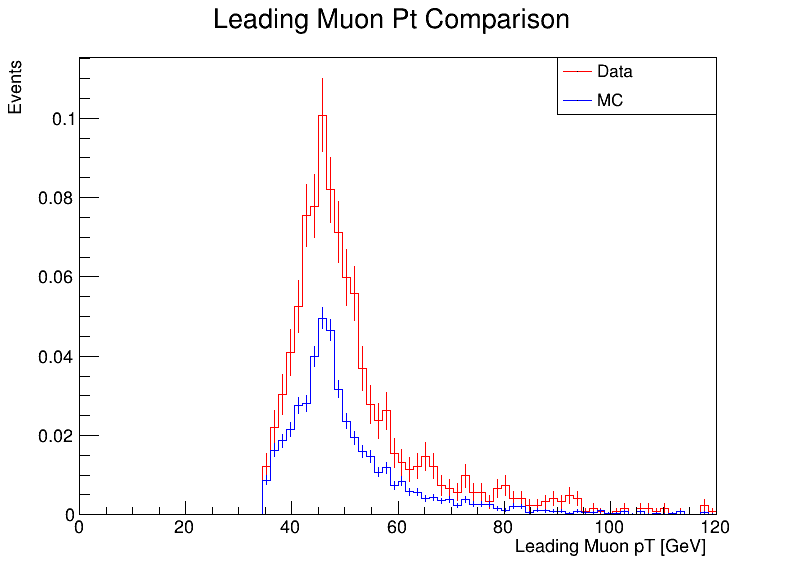

In [11]:
c = rt.TCanvas("c", "c", 800, 600)
stack_leading = rt.THStack("stack","Leading Muon Pt Comparison")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Leading Muon Pt Distribution for Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_LeadingPt.Fill(getattr(data_tree, "lepPt")[0])
data_LeadingPt.SetLineColor(rt.kRed)
data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
print(type(data_LeadingPt))
stack_leading.Add(data_LeadingPt)


MC_LeadingPt = rt.TH1F("LeadingPt_MC", "Leading Muon Pt Distribution for MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_LeadingPt.Fill(getattr(MC_tree, "lepPt")[0], getattr(MC_tree, "weight"))
MC_LeadingPt.SetLineColor(rt.kBlue)
MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
print(type(MC_LeadingPt))
stack_leading.Add(MC_LeadingPt)

stack_leading.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_LeadingPt, "Data")
legend.AddEntry(MC_LeadingPt, "MC")
legend.Draw()

stack_leading.GetXaxis().SetTitle("Leading Muon pT [GeV]");
stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


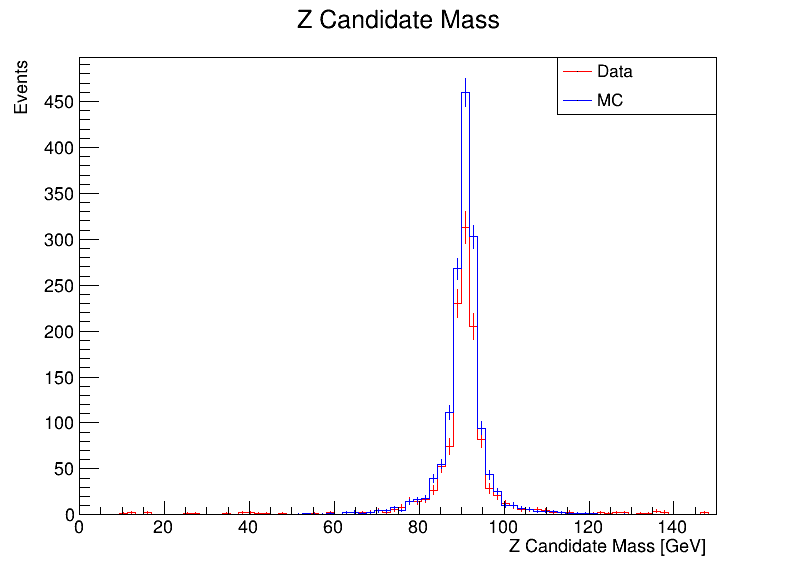

In [37]:
c = rt.TCanvas("c", "c", 800, 600)
stack_leading = rt.THStack("stack","Z Candidate Mass")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Leading Muon Pt Distribution for Data", nbinsx=80, xlow = 0, xup=150)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_LeadingPt.Fill(getattr(data_tree, "ZMass"))
data_LeadingPt.SetLineColor(rt.kRed)
#data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
stack_leading.Add(data_LeadingPt)


MC_LeadingPt = rt.TH1F("LeadingPt_MC", "Leading Muon Pt Distribution for MC", nbinsx=80, xlow = 0, xup=150)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_LeadingPt.Fill(getattr(MC_tree, "ZMass"), getattr(MC_tree, "weight"))
MC_LeadingPt.SetLineColor(rt.kBlue)
#MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
stack_leading.Add(MC_LeadingPt)

stack_leading.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_LeadingPt, "Data")
legend.AddEntry(MC_LeadingPt, "MC")
legend.Draw()

stack_leading.GetXaxis().SetTitle("Z Candidate Mass [GeV]");
stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

In [78]:
#c = rt.TCanvas("c", "c", 800, 600)
#stack_leading = rt.THStack("stack","Z Candidate Mass")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=150)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_LeadingPt.Fill(getattr(data_tree, "ZMass"))
data_LeadingPt.SetLineColor(rt.kBlack)
#data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
#stack_leading.Add(data_LeadingPt)


MC_LeadingPt = rt.TH1F("LeadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=150)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_LeadingPt.Fill(getattr(MC_tree, "ZMass"), getattr(MC_tree, "weight"))
MC_LeadingPt.SetLineColor(rt.kRed)
#MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
#stack_leading.Add(MC_LeadingPt)

Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


In [51]:
c = rt.TCanvas("c", "c", 800, 600)
stack_SubleadingPt = rt.THStack("stack","Subleading Muon Pt Comparison")
data_SubleadingPt = rt.TH1F("SubleadingPt_Data", "Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_SubleadingPt.Fill(getattr(data_tree, "lepPt")[1])
data_SubleadingPt.SetLineColor(rt.kBlack)
#data_SubleadingPt.Scale(1/data_SubleadingPt.GetEntries())



MC_SubleadingPt = rt.TH1F("SubleadingPt_MC", "MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_SubleadingPt.Fill(getattr(MC_tree, "lepPt")[1], getattr(data_tree, "weight"))
MC_SubleadingPt.SetLineColor(rt.kRed)
#MC_SubleadingPt.Scale(1/MC_SubleadingPt.GetEntries())


Warning in <TFile::Append>: Replacing existing TH1: SubleadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: SubleadingPt_MC (Potential memory leak).


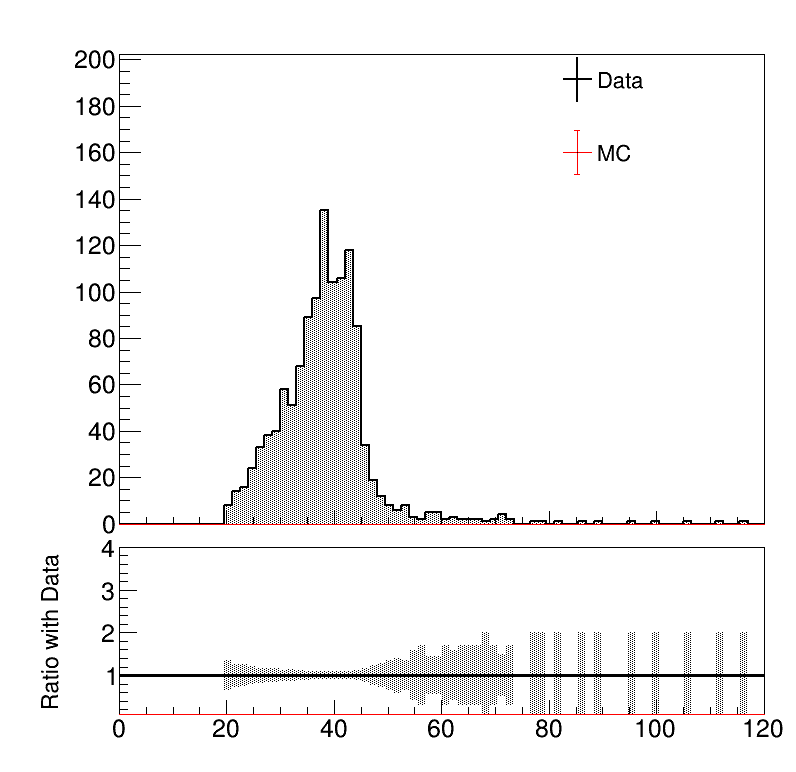

In [52]:
c.Clear()
rt.gStyle.SetOptStat(0);
c = make_ratio_plot([data_SubleadingPt, MC_SubleadingPt], title = "", label = "", fit = False, in_tags = None, ratio_bounds = [0.1, 4], logy = False, ratio_index = 0, draw_opt = ['hist','E1'], text = "")
#legend = rt.TLegend(0.9,0.8,0.7,0.9)
#legend.AddEntry(data_LeadingPt, "Data")
#legend.AddEntry(MC_LeadingPt, "MC")
#legend.Draw()

#stack_leading.GetXaxis().SetTitle("Z Candidate Mass [GeV]");
#stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

In [ ]:
c = rt.TCanvas("c", "c", 800, 600)
stack_SubleadingPt = rt.THStack("stack","Subleading Muon Pt Comparison")
data_SubleadingPt = rt.TH1F("SubleadingPt_Data", "Subleading Muon Pt Distribution for Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_SubleadingPt.Fill(getattr(data_tree, "lepPt")[1])
data_SubleadingPt.SetLineColor(rt.kRed)
#data_SubleadingPt.Scale(1/data_SubleadingPt.GetEntries())
#stack_SubleadingPt.Add(data_SubleadingPt)


MC_SubleadingPt = rt.TH1F("SubleadingPt_MC", "Subleading Muon Pt Distribution for MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_SubleadingPt.Fill(getattr(MC_tree, "lepPt")[1], getattr(MC_tree, "weight"))
MC_SubleadingPt.SetLineColor(rt.kBlue)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


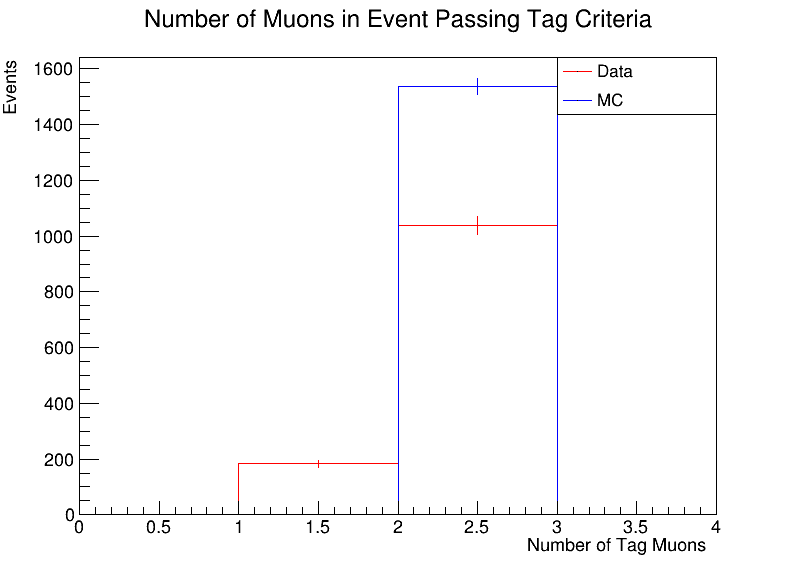

In [44]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Number of Muons in Event Passing Tag Criteria")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=4, xlow = 0, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    counter=0
    for i in range(data_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            counter+=1
    data_clusterSize.Fill(counter)
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=4, xlow = 0, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    counter=0
    for i in range(MC_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            counter+=1
    MC_clusterSize.Fill(counter, getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Number of Tag Muons");
stack_clusterSize.GetYaxis().SetTitle("Events");
#c.SetLogy();
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: SubleadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: SubleadingPt_MC (Potential memory leak).


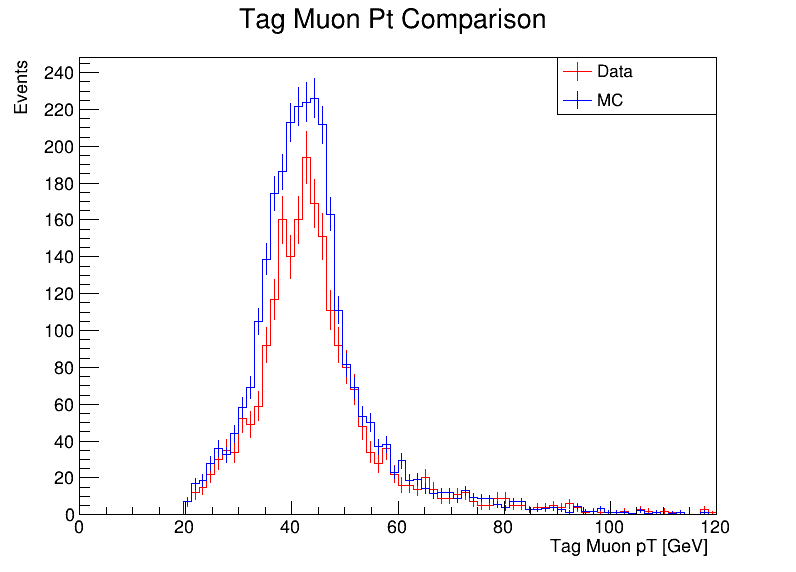

In [47]:
c = rt.TCanvas("c", "c", 800, 600)
stack_SubleadingPt = rt.THStack("stack","Tag Muon Pt Comparison")
data_SubleadingPt = rt.TH1F("SubleadingPt_Data", "Subleading Muon Pt Distribution for Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nLeptons):
        if data_tree.lepTag[i]==1:
            data_SubleadingPt.Fill(getattr(data_tree, "lepPt")[i])
data_SubleadingPt.SetLineColor(rt.kRed)
#data_SubleadingPt.Scale(1/data_SubleadingPt.GetEntries())
stack_SubleadingPt.Add(data_SubleadingPt)


MC_SubleadingPt = rt.TH1F("SubleadingPt_MC", "Subleading Muon Pt Distribution for MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    for i in range(MC_tree.nLeptons):
        if MC_tree.lepTag[i]==1:
            MC_SubleadingPt.Fill(getattr(MC_tree, "lepPt")[i], MC_tree.weight)
MC_SubleadingPt.SetLineColor(rt.kBlue)
#MC_SubleadingPt.Scale(1/MC_SubleadingPt.GetEntries())
stack_SubleadingPt.Add(MC_SubleadingPt)

stack_SubleadingPt.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_SubleadingPt, "Data", "lep")
legend.AddEntry(MC_SubleadingPt, "MC", "lep")
legend.Draw()

stack_SubleadingPt.GetXaxis().SetTitle("Tag Muon pT [GeV]");
stack_SubleadingPt.GetYaxis().SetTitle("Events");

c.Draw()

### Eta of All Muons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


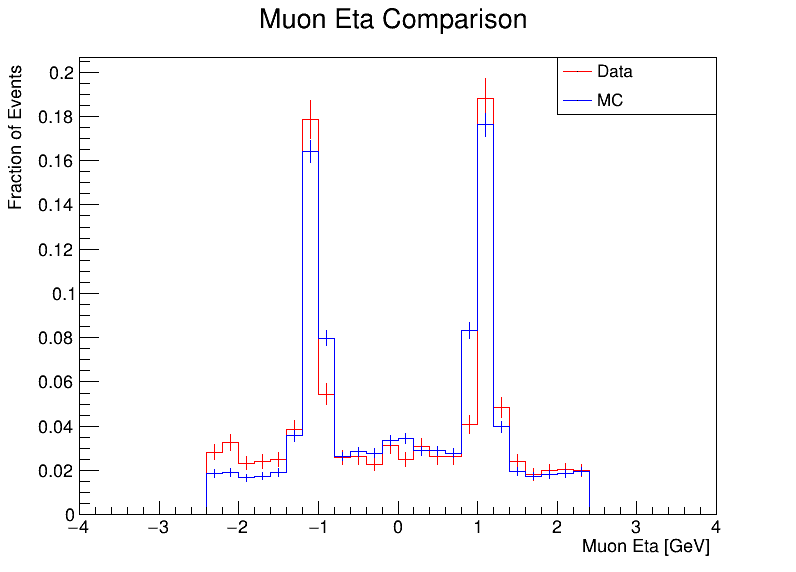

In [13]:
c = rt.TCanvas("c", "c", 800, 600)
stack_eta = rt.THStack("stack","Muon Eta Comparison")
data_eta = rt.TH1F("Eta_Data", "Eta Distribution for Data", nbinsx=40, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_eta.Fill(getattr(data_tree, "lepEta")[0])
    data_eta.Fill(getattr(data_tree, "lepEta")[1])
data_eta.SetLineColor(rt.kRed)
data_eta.Scale(1/data_eta.GetEntries())
stack_eta.Add(data_eta)


MC_eta = rt.TH1F("Eta", "Eta Distribution for MC", nbinsx=40, xlow = -4, xup=4)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_eta.Fill(getattr(MC_tree, "lepEta")[0])
    MC_eta.Fill(getattr(MC_tree, "lepEta")[1])
MC_eta.SetLineColor(rt.kBlue)
MC_eta.Scale(1/MC_eta.GetEntries())
stack_eta.Add(MC_eta)

stack_eta.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_eta, "Data")
legend.AddEntry(MC_eta, "MC")
legend.Draw()

stack_eta.GetXaxis().SetTitle("Muon Eta [GeV]");
stack_eta.GetYaxis().SetTitle("Fraction of Events");

c.Draw()

### Phi

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: Eta (Potential memory leak).


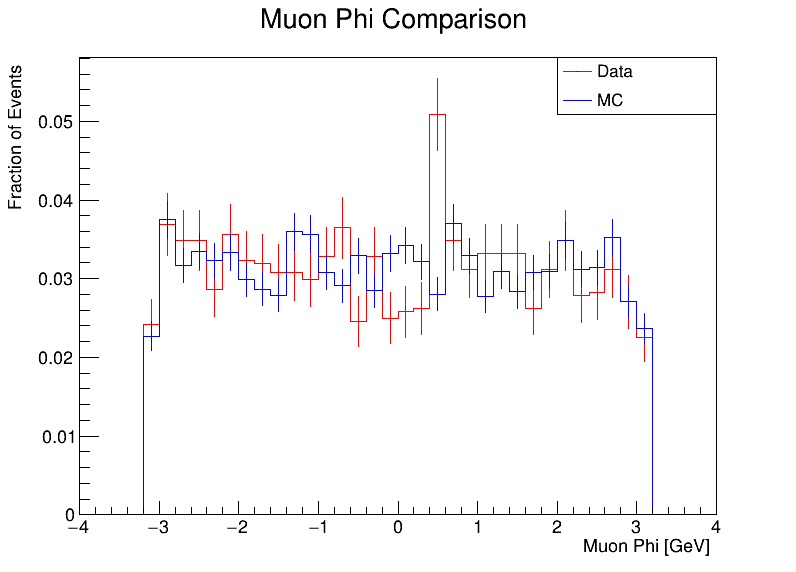

In [14]:
c = rt.TCanvas("c", "c", 800, 600)
stack_phi = rt.THStack("stack","Muon Phi Comparison")
data_phi = rt.TH1F("Phi_Data", "Phi Distribution for Data", nbinsx=40, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    data_phi.Fill(getattr(data_tree, "lepPhi")[0])
    data_phi.Fill(getattr(data_tree, "lepPhi")[1])
data_phi.SetLineColor(rt.kRed)
data_phi.Scale(1/data_phi.GetEntries())
stack_phi.Add(data_phi)


MC_phi= rt.TH1F("Eta", "Eta Distribution for MC", nbinsx=40, xlow = -4, xup=4)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    MC_phi.Fill(getattr(MC_tree, "lepPhi")[0])
    MC_phi.Fill(getattr(MC_tree, "lepPhi")[1])
MC_phi.SetLineColor(rt.kBlue)
MC_phi.Scale(1/MC_phi.GetEntries())
stack_phi.Add(MC_phi)

stack_phi.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_phi, "Data")
legend.AddEntry(MC_phi, "MC")
legend.Draw()

stack_phi.GetXaxis().SetTitle("Muon Phi [GeV]");
stack_phi.GetYaxis().SetTitle("Fraction of Events");

c.Draw()

### Properties of Muons Matched to Clusters

In [15]:
def deltaR(eta1, phi1, eta2, phi2):
    return np.sqrt((eta1-eta2)**2+(phi1-phi2)**2)

1221
3254


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


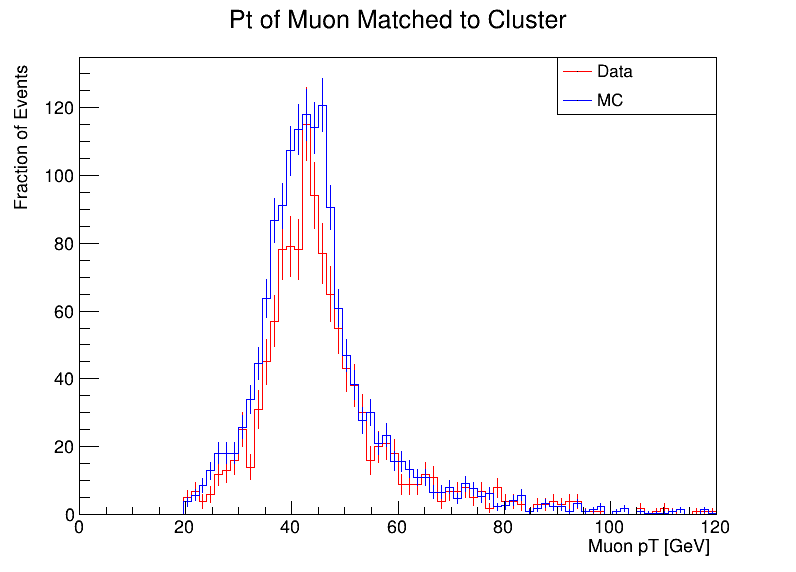

In [16]:
c = rt.TCanvas("c", "c", 800, 600)
stack_leading = rt.THStack("stack","Pt of Muon Matched to Cluster")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Leading Muon Pt Distribution for Data", nbinsx=80, xlow = 0, xup=120)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
data_cluster_count = 0
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if not (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            continue
        for j in range(data_tree.nLeptons):
            if deltaR(data_tree.lepEta[j],data_tree.lepPhi[j], data_tree.cscRechitClusterEta[i],data_tree.cscRechitClusterPhi[i])<0.4:
                data_LeadingPt.Fill(data_tree.lepPt[j])
                data_cluster_count+=1
data_LeadingPt.SetLineColor(rt.kRed)
#data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
stack_leading.Add(data_LeadingPt)
print(data_cluster_count)

MC_cluster_count=0
MC_LeadingPt = rt.TH1F("LeadingPt_MC", "Leading Muon Pt Distribution for MC", nbinsx=80, xlow = 0, xup=120)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if not (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            continue
        for j in range(MC_tree.nLeptons):
            if deltaR(MC_tree.lepEta[j],MC_tree.lepPhi[j], MC_tree.cscRechitClusterEta[i],MC_tree.cscRechitClusterPhi[i])<0.4:
                MC_LeadingPt.Fill(MC_tree.lepPt[j], getattr(MC_tree, "weight"))
                MC_cluster_count+=1
MC_LeadingPt.SetLineColor(rt.kBlue)
#MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
stack_leading.Add(MC_LeadingPt)

stack_leading.Draw("nostack HIST E0")
print(MC_cluster_count)

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_LeadingPt, "Data")
legend.AddEntry(MC_LeadingPt, "MC")
legend.Draw()

stack_leading.GetXaxis().SetTitle("Muon pT [GeV]");
stack_leading.GetYaxis().SetTitle("Fraction of Events");

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


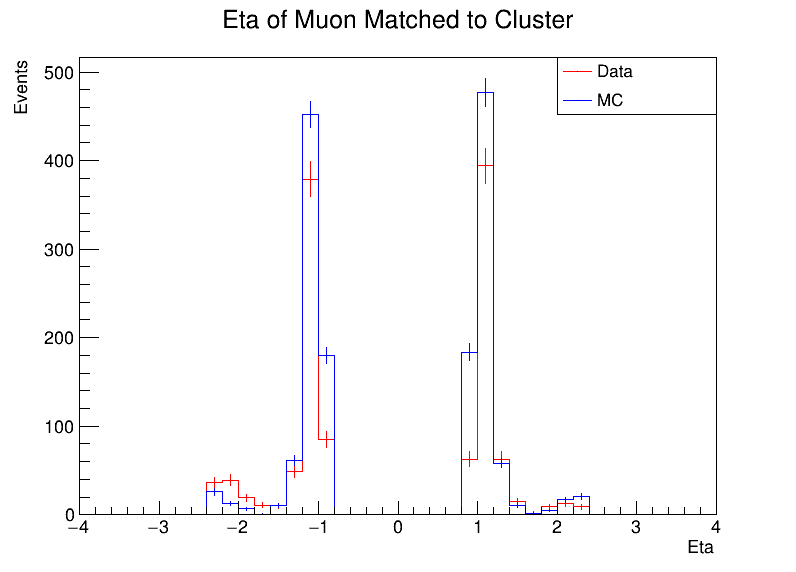

In [17]:
c = rt.TCanvas("c", "c", 800, 600)
stack_leading = rt.THStack("stack","Eta of Muon Matched to Cluster")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Leading Muon Pt Distribution for Data", nbinsx=40, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if not (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i] and data_tree.Flag_CSCTightHaloFilter==1):
            continue
        for j in range(data_tree.nLeptons):
            if deltaR(data_tree.lepEta[j],data_tree.lepPhi[j], data_tree.cscRechitClusterEta[i],data_tree.cscRechitClusterPhi[i])<0.4:
                data_LeadingPt.Fill(data_tree.lepEta[j])
data_LeadingPt.SetLineColor(rt.kRed)
#data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
stack_leading.Add(data_LeadingPt)


MC_LeadingPt = rt.TH1F("LeadingPt_MC", "Leading Muon Pt Distribution for MC", nbinsx=40, xlow = -4, xup=4)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if not (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            continue
        for j in range(MC_tree.nLeptons):
            if deltaR(MC_tree.lepEta[j],MC_tree.lepPhi[j], MC_tree.cscRechitClusterEta[i],MC_tree.cscRechitClusterPhi[i])<0.4:
                MC_LeadingPt.Fill(MC_tree.lepEta[j], getattr(MC_tree, "weight"))
MC_LeadingPt.SetLineColor(rt.kBlue)
#MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
stack_leading.Add(MC_LeadingPt)

stack_leading.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_LeadingPt, "Data")
legend.AddEntry(MC_LeadingPt, "MC")
legend.Draw()

stack_leading.GetXaxis().SetTitle("Eta");
stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: LeadingPt_MC (Potential memory leak).


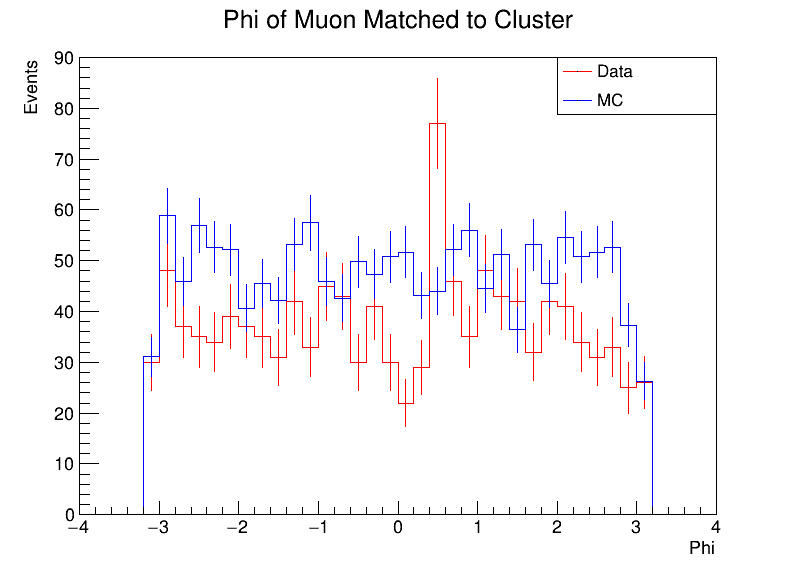

In [18]:
c = rt.TCanvas("c", "c", 800, 600)
stack_leading = rt.THStack("stack","Phi of Muon Matched to Cluster")
data_LeadingPt = rt.TH1F("LeadingPt_Data", "Leading Muon Pt Distribution for Data", nbinsx=40, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if not (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i] and data_tree.Flag_CSCTightHaloFilter==1):
            continue
        for j in range(data_tree.nLeptons):
            if deltaR(data_tree.lepEta[j],data_tree.lepPhi[j], data_tree.cscRechitClusterEta[i],data_tree.cscRechitClusterPhi[i])<0.4:
                data_LeadingPt.Fill(data_tree.lepPhi[j])
data_LeadingPt.SetLineColor(rt.kRed)
#data_LeadingPt.Scale(1/data_LeadingPt.GetEntries())
stack_leading.Add(data_LeadingPt)


MC_LeadingPt = rt.TH1F("LeadingPt_MC", "Leading Muon Pt Distribution for MC", nbinsx=40, xlow = -4, xup=4)
#MC_LeadingPt.Project("LeadingPt_MC", "LeadingMC")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if not (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            continue
        for j in range(MC_tree.nLeptons):
            if deltaR(MC_tree.lepEta[j],MC_tree.lepPhi[j], MC_tree.cscRechitClusterEta[i],MC_tree.cscRechitClusterPhi[i])<0.4:
                MC_LeadingPt.Fill(MC_tree.lepPhi[j], getattr(MC_tree, "weight"))
MC_LeadingPt.SetLineColor(rt.kBlue)
#MC_LeadingPt.Scale(1/MC_LeadingPt.GetEntries())
stack_leading.Add(MC_LeadingPt)

stack_leading.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_LeadingPt, "Data")
legend.AddEntry(MC_LeadingPt, "MC")
legend.Draw()

stack_leading.GetXaxis().SetTitle("Phi");
stack_leading.GetYaxis().SetTitle("Events");

c.Draw()

### Cluster Properties

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


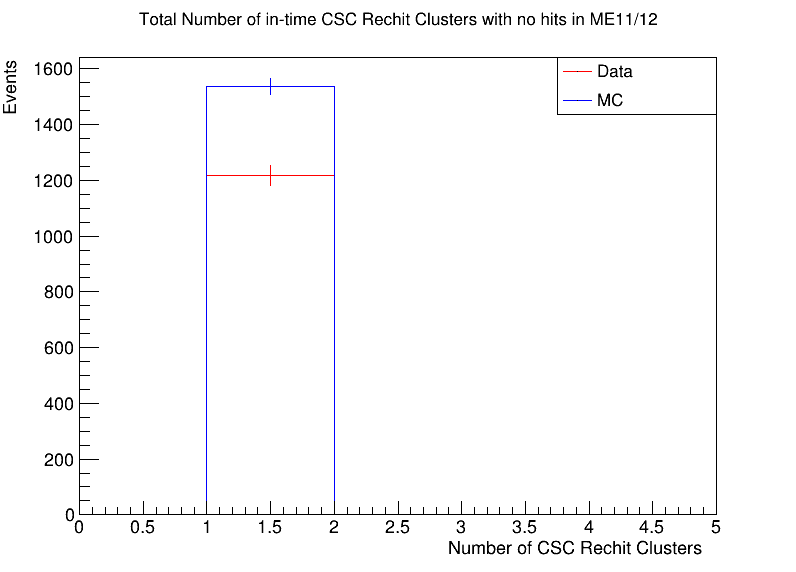

In [56]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Total Number of in-time CSC Rechit Clusters with no hits in ME11/12")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=5, xlow = 0, xup=5)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    counter=0
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            counter+=1
    data_clusterSize.Fill(counter)
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=5, xlow = 0, xup=5)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    counter=0
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            counter+=1
    MC_clusterSize.Fill(counter, getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Number of CSC Rechit Clusters");
stack_clusterSize.GetYaxis().SetTitle("Events");
#c.SetLogy();
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


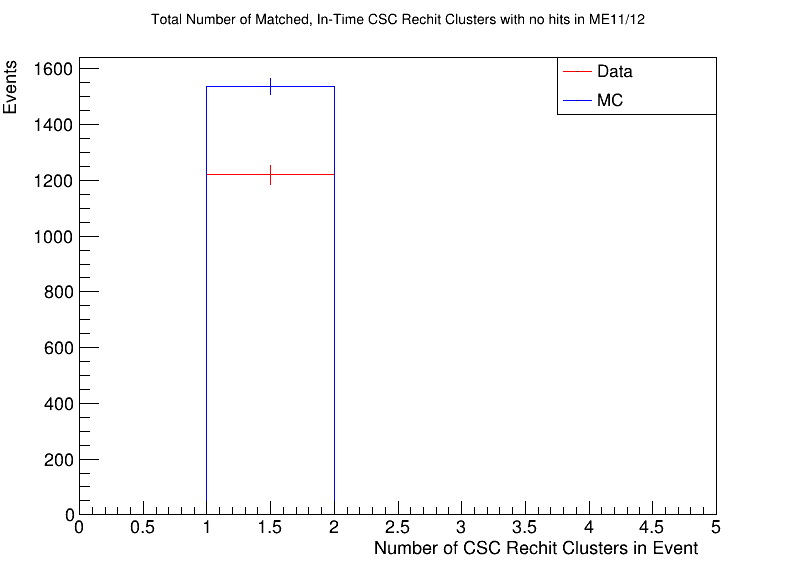

In [55]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Total Number of Matched, In-Time CSC Rechit Clusters with no hits in ME11/12")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=5, xlow = 0, xup=5)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    counter=0
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            counter+=1
    data_clusterSize.Fill(counter)
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=5, xlow = 0, xup=5)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    counter=0
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            counter+=1
    MC_clusterSize.Fill(counter, getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Number of CSC Rechit Clusters in Event");
stack_clusterSize.GetYaxis().SetTitle("Events");
#c.SetLogy();
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


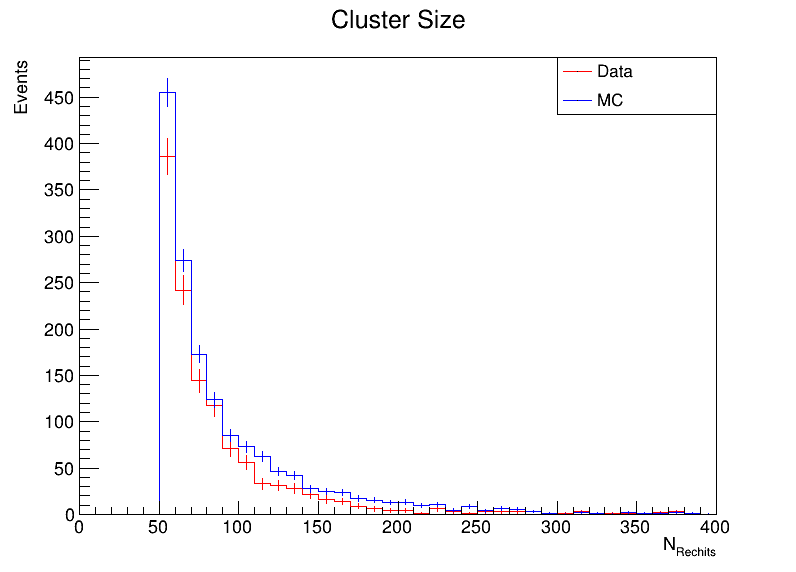

In [57]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Cluster Size")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=40, xlow = 0, xup=400)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterSize[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=40, xlow = 0, xup=400)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterSize[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("N_{Rechits}");
stack_clusterSize.GetYaxis().SetTitle("Events");
#c.SetLogy();
c.Draw()

skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped
skipped


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


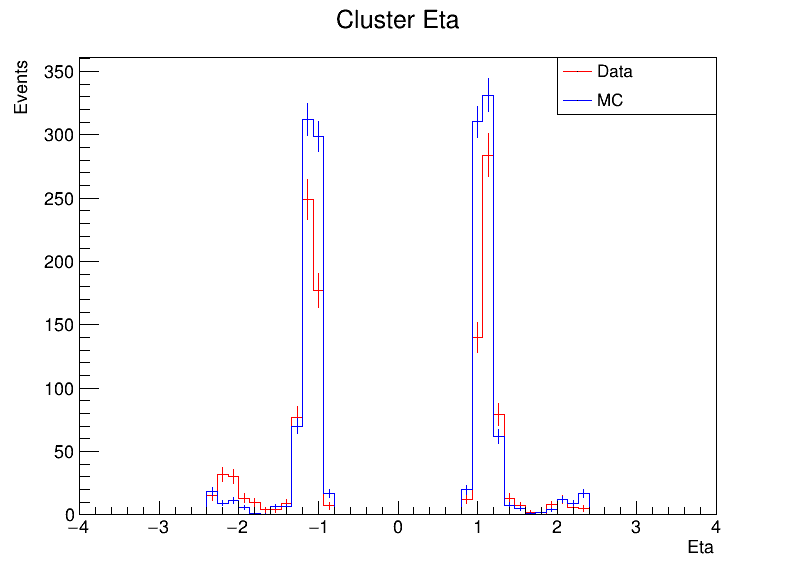

In [22]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Cluster Eta")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=60, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    if data_tree.Flag_CSCTightHaloFilter == 0:
        print("skipped")
        continue
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterEta[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=60, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterEta[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Eta")
stack_clusterSize.GetYaxis().SetTitle("Events")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


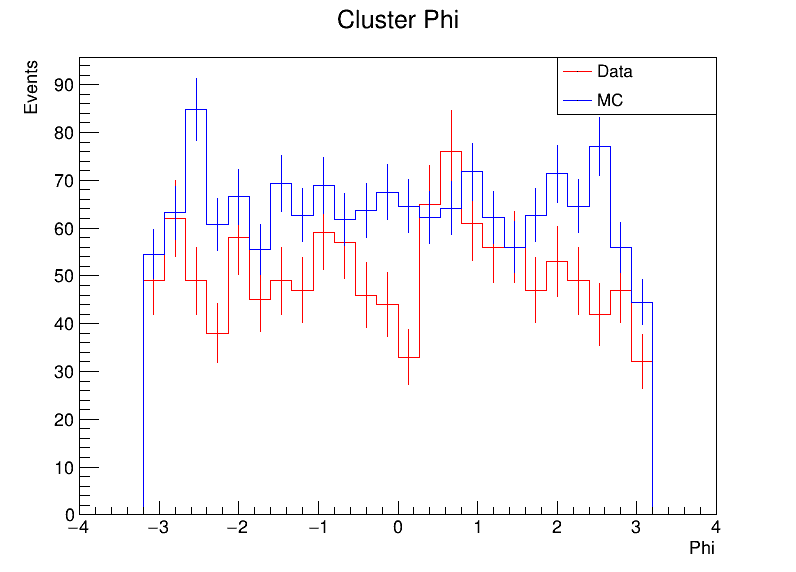

In [58]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Cluster Phi")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=30, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    #if data_tree.Flag_CSCTightHaloFilter == 0:
    #    print("skipped")
    #    continue
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterPhi[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=30, xlow = -4, xup=4)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterPhi[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Phi")
stack_clusterSize.GetYaxis().SetTitle("Events")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


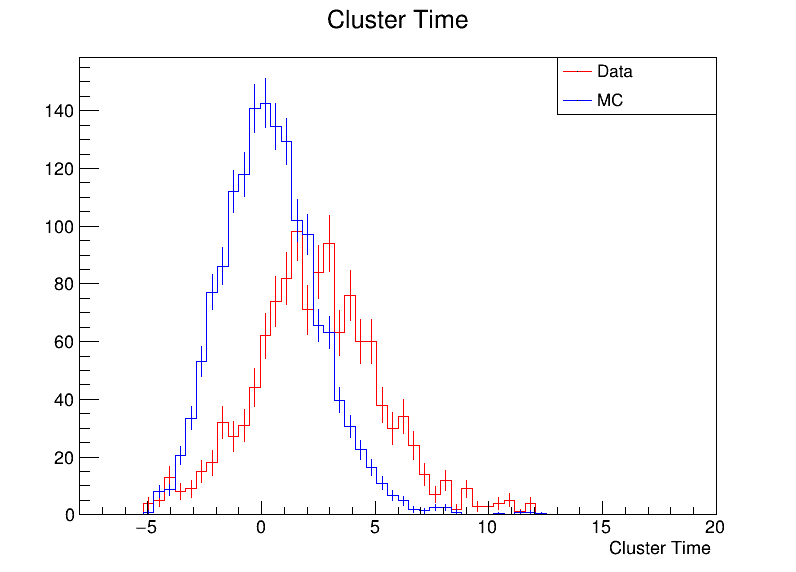

In [59]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Cluster Time")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=60, xlow = -8, xup=20)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterTime[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=60, xlow = -8, xup=20)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterTime[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Cluster Time")
#stack_clusterSize.GetYaxis().SetTitle("Fraction of Events")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


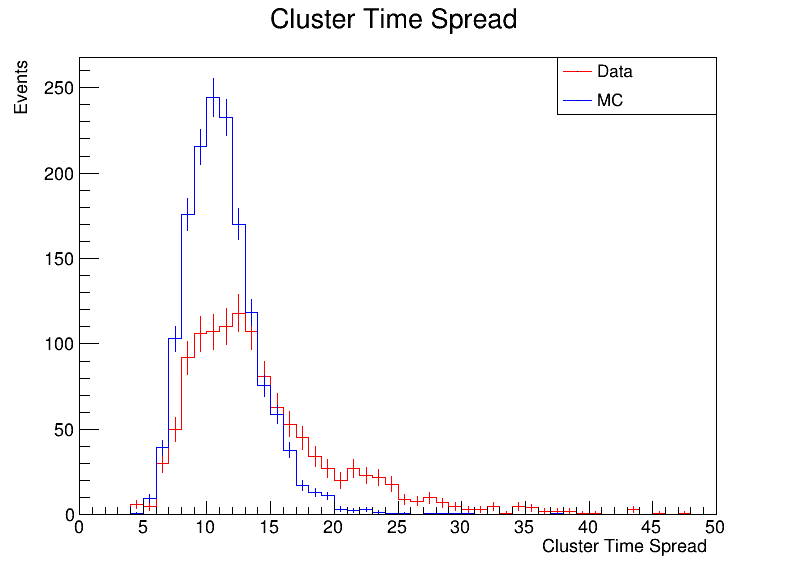

In [25]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Cluster Time Spread")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=50, xlow = 0, xup=50)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterTimeSpread[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=50, xlow = 0, xup=50)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterTimeSpread[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Cluster Time Spread")
stack_clusterSize.GetYaxis().SetTitle("Events")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


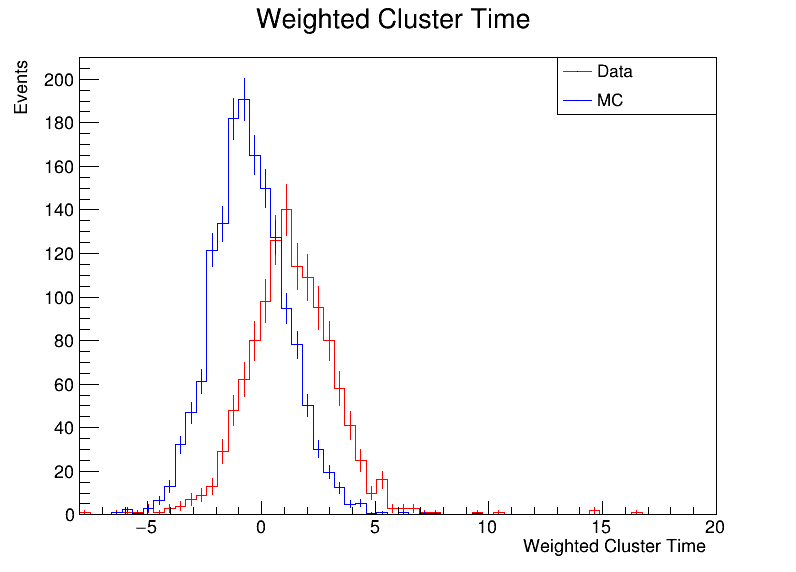

In [60]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Weighted Cluster Time")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=60, xlow = -8, xup=20)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterTimeWeighted[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=60, xlow = -8, xup=20)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterTimeWeighted[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Weighted Cluster Time")
stack_clusterSize.GetYaxis().SetTitle("Events")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_Data (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: ClusterSize_MC (Potential memory leak).


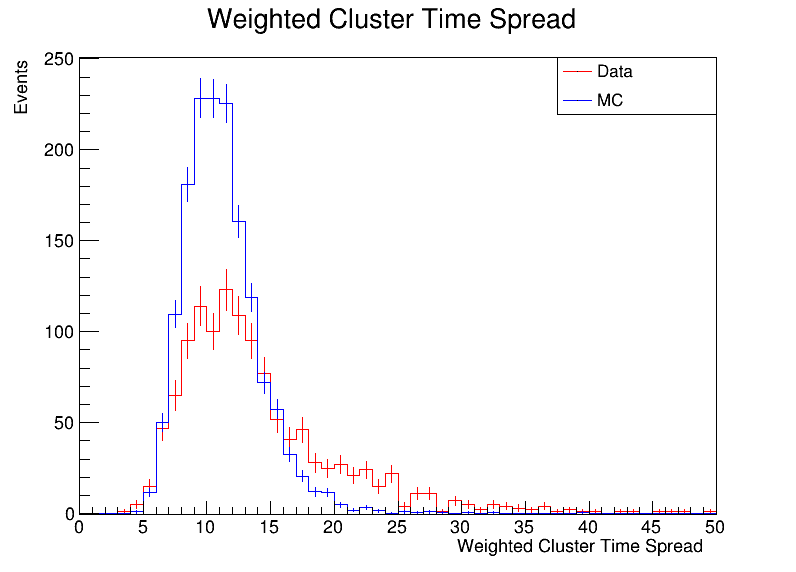

In [27]:
c = rt.TCanvas("c", "c", 800, 600)
stack_clusterSize = rt.THStack("stack","Weighted Cluster Time Spread")
data_clusterSize = rt.TH1F("ClusterSize_Data", "Cluster Size Distribution for Data", nbinsx=50, xlow = 0, xup=50)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in data_tree:
    for i in range(data_tree.nCscRechitClusters):
        if (data_tree.cscRechitCluster_matchToProbeMuon[i] and data_tree.cscRechitCluster_passME1112Veto[i] and data_tree.cscRechitCluster_PassTimeVeto[i]):
            data_clusterSize.Fill(data_tree.cscRechitClusterTimeSpreadWeightedAll[i])
data_clusterSize.SetLineColor(rt.kRed)
#data_clusterSize.Scale(1/data_clusterSize.GetEntries())
stack_clusterSize.Add(data_clusterSize)


MC_clusterSize = rt.TH1F("ClusterSize_MC", "Cluster Size Distribution for MC", nbinsx=50, xlow = 0, xup=50)
#data_LeadingPt.Project("LeadingPt_Data", "LeadingPt")
for entry in MC_tree:
    for i in range(MC_tree.nCscRechitClusters):
        if (MC_tree.cscRechitCluster_matchToProbeMuon[i] and MC_tree.cscRechitCluster_passME1112Veto[i] and MC_tree.cscRechitCluster_PassTimeVeto[i]):
            MC_clusterSize.Fill(MC_tree.cscRechitClusterTimeSpreadWeightedAll[i], getattr(MC_tree, "weight"))
MC_clusterSize.SetLineColor(rt.kBlue)
#MC_clusterSize.Scale(1/MC_clusterSize.GetEntries())
stack_clusterSize.Add(MC_clusterSize)

stack_clusterSize.Draw("nostack HIST E0")

legend = rt.TLegend(0.9,0.8,0.7,0.9)
legend.AddEntry(data_clusterSize, "Data")
legend.AddEntry(MC_clusterSize, "MC")
legend.Draw()

stack_clusterSize.GetXaxis().SetTitle("Weighted Cluster Time Spread")
stack_clusterSize.GetYaxis().SetTitle("Events")

c.Draw()